In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy as sp

import holodeck as holo
import holodeck.single_sources as ss
import holodeck.detstats as det
from holodeck.constants import YR, MSOL
from holodeck import utils


import hasasia.sensitivity as hsen
import hasasia.sim as hsim

# Build SAM and calculate strains

Make the semi-analytic model object.

In [24]:
# dur = 10.0*YR
# cad = 0.2*YR
# fobs = utils.nyquist_freqs(dur,cad)
# fobs_edges = utils.nyquist_freqs_edges(dur,cad)
# sam = holo.sam.Semi_Analytic_Model() 
# # sam = holo.sam.Semi_Analytic_Model(mtot=(1.0e4*MSOL, 1.0e11*MSOL, 20), mrat=(1e-3, 1.0, 20), redz=(1e-3, 10.0, 20))  # faster version
# hard = holo.hardening.Hard_GW
# fobs_orb_edges = fobs_edges / 2.0 
# fobs_orb_cents = fobs/ 2.0
# # edges
# edges, dnum = sam.dynamic_binary_number(hard, fobs_orb=fobs_orb_cents) # should the zero stalled option be part of the parameter space?
# edges[-1] = fobs_orb_edges
# dfobs = np.diff(edges[-1])
# # integrate for number
# number = utils._integrate_grid_differential_number(edges, dnum, freq=False)
# number = number * np.diff(np.log(fobs_edges)) 
# hc_ss, hc_bg = ss.ss_gws(edges, number, realize=1, 
#                                         loudest = 1, params = False) 
# np.savez('/Users/emigardiner/GWs/holodeck/ecg-notebooks/detstats_functions/sample_sam_A.npz', 
#          dur=dur, cad=cad, fobs=fobs, dfobs=dfobs, hc_ss=hc_ss, hc_bg=hc_bg)

In [25]:
hcfile = np.load('/Users/emigardiner/GWs/holodeck/ecg-notebooks/detstats_functions/sample_sam_A.npz')
dur = hcfile['dur']
cad = hcfile['cad']
fobs = hcfile['fobs']
dfobs = hcfile['dfobs']
hc_ss = hcfile['hc_ss']
hc_bg = hcfile['hc_bg']

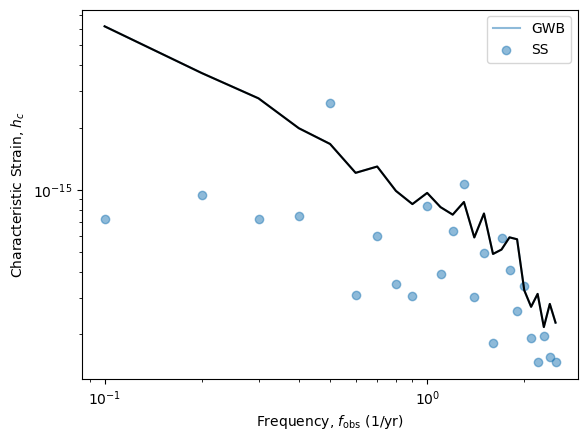

In [26]:
def plot_hc():
    nreals = np.min([10, len(hc_bg[0])])
    colors = cm.rainbow(np.linspace(0,1,nreals))
    plt.xlabel('Frequency, $f_\mathrm{obs}$ (1/yr)')
    plt.ylabel('Characteristic Strain, $h_c$')
    for rr in range(nreals):
        if(rr==0):
            label_bg = 'GWB'
            label_ss = 'SS'
        else:
            label_bg = None
            label_ss = None
        plt.loglog(fobs*YR, hc_bg[:,rr], alpha=0.5, label=label_bg)
        plt.scatter(fobs*YR, hc_ss[:,rr], alpha=0.5, label=label_ss)
    plt.loglog(fobs*YR, np.median(hc_bg, axis=1), color='k')
    plt.legend()

plot_hc()

# Set up 2 pulsars
* 2 pulsars
* 45 degrees ($\pi$/4) apart in $\phi$
* same $\theta=0$

In [27]:
# set pulsar parameters
npsrs = 2
phis = np.array([0,np.pi/4])
thetas = np.array([0,0])
sigmas = np.array([1e-7,1e-7])
# build sim_pta
pulsars = hsim.sim_pta(timespan=dur/YR, cad=1/(cad/YR), sigma=sigmas,
                       phi=phis, theta=thetas)
# get spectrum for each
spectra = np.empty_like(pulsars, dtype=hsen.Spectrum)
for ii in range(npsrs):
    spectra[ii] = hsen.Spectrum(pulsars[ii], freqs=fobs)
    spectra[ii].NcalInv # calculate inverse noise weighted transmission function
# get sensitivity curve
scDeter = hsen.DeterSensitivityCurve(list(spectra))

And it's deterministic sensitivity curve.

# Calculate the single source detection probability

Place the single sources randomly across the sky
Isolate the 5th frequency bin source, place it.

In [45]:
# theta_ss = np.random.uniform(0, np.pi, size = hc_ss.size).reshape(hc_ss.shape)
# phi_ss = np.random.uniform(0, 2*np.pi, size = hc_ss.size).reshape(hc_ss.shape)
# iota_ss = np.random.uniform(0, np.pi, size = hc_ss.size).reshape(hc_ss.shape)
# xi_ss = np.random.uniform(0, np.pi, size = hc_ss.size).reshape(hc_ss.shape) 
# Phi0_ss = np.random.uniform(0,2*np.pi, size=hc_ss.size).reshape(hc_ss.shape)
# np.savez('/Users/emigardiner/GWs/holodeck/ecg-notebooks/detstats_functions/random_binary_angles_A.npz',
#          theta_ss=theta_ss, phi_ss=phi_ss, iota_ss=iota_ss, xi_ss=xi_ss, Phi0_ss=Phi0_ss)
infile = np.load('/Users/emigardiner/GWs/holodeck/ecg-notebooks/detstats_functions/random_binary_angles_A.npz')
theta_ss = infile['theta_ss']
phi_ss = infile['phi_ss']
iota_ss = infile['iota_ss']
xi_ss = infile['xi_ss']
Phi0_ss = infile['Phi0_ss']

# # special 5th bin:
ss=4
def reset_ss():
    theta_ss[ss,0,0] = np.pi/8
    phi_ss[ss,0,0] = np.pi/8
    iota_ss[ss,0,0] = 0
    xi_ss[ss,0,0] = 0
    Phi0_ss[ss,0,0] = 0
    hc_ss = hcfile['hc_ss']
reset_ss()

Detection probability by 3 methods:
* det = detect_ss() uses the stored arrays with Rosado equations
* pta = detect_ss_pta() uses the pulsar list object with Rosado equations
* has = detect_ss_scDeter() uses the hasasia.DeterSensitivityCurve SNR's to calculate dp

In [46]:
dp_det, snr_det = det.detect_ss(thetas, phis, sigmas, cad, dur, fobs, dfobs, hc_ss, hc_bg,
                                ret_SNR = True, theta_ss=theta_ss, phi_ss=phi_ss, 
                                iota_ss=iota_ss, xi_ss=xi_ss, Phi0_ss=Phi0_ss)
print(dp_det, snr_det.shape, snr_det.squeeze())
dp_pta, snr_pta = det.detect_ss_pta(pulsars, cad, dur, fobs, dfobs, hc_ss, hc_bg,
                                ret_SNR = True, theta_ss=theta_ss, phi_ss=phi_ss, 
                                iota_ss=iota_ss, xi_ss=xi_ss, Phi0_ss=Phi0_ss)
print(dp_pta, snr_pta.shape, snr_pta.squeeze())
dp_has, snr_has = det.detect_ss_scDeter(pulsars, scDeter, hc_ss,
                                ret_SNR = True, theta_ss=theta_ss, phi_ss=phi_ss, 
                                iota_ss=iota_ss, xi_ss=xi_ss, Phi0_ss=Phi0_ss)
print(dp_has, snr_has.shape, snr_has.squeeze())


[0.00105783] (25, 1, 1) [1.26576603e-01 8.50295005e-02 2.04304616e-02 2.46391233e-01
 5.56049806e-01 2.26222578e-02 1.08912941e-02 1.75000359e-02
 2.45543557e-02 4.68226789e-02 3.03803928e-02 2.06549215e-02
 2.08821884e-02 1.74965090e-02 1.67184174e-03 6.05793280e-03
 3.22474607e-02 1.82505398e-02 1.06134249e-04 3.64197715e-03
 7.84005147e-05 5.57551143e-04 3.82592778e-03 7.59976659e-04
 8.34541798e-05]
[0.00105783] (25, 1, 1) [1.26576603e-01 8.50295005e-02 2.04304616e-02 2.46391233e-01
 5.56049806e-01 2.26222578e-02 1.08912941e-02 1.75000359e-02
 2.45543557e-02 4.68226789e-02 3.03803928e-02 2.06549215e-02
 2.08821884e-02 1.74965090e-02 1.67184174e-03 6.05793280e-03
 3.22474607e-02 1.82505398e-02 1.06134249e-04 3.64197715e-03
 7.84005147e-05 5.57551143e-04 3.82592778e-03 7.59976659e-04
 8.34541798e-05]
[0.00146526] (25, 1, 1) [6.61237187e-01 8.12995220e-01 4.27891824e-01 3.36891749e-01
 9.56047620e-01 9.35011668e-02 1.52804861e-01 7.70281185e-02
 5.24176509e-02 2.27765923e-16 5.4473321

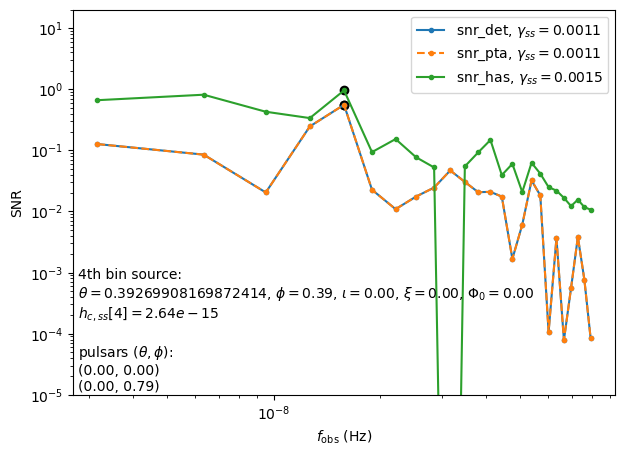

In [47]:
def plot_snr():
        fig,ax = plt.subplots(figsize=(7,5))
        ax.loglog(fobs, snr_det.squeeze(), label='snr_det, $\gamma_{ss}=%.4f$' % dp_det, marker='.')
        ax.loglog(fobs, snr_pta.squeeze(), label='snr_pta, $\gamma_{ss}=%.4f$' % dp_pta, marker='.', linestyle='--') # should be exact same, check!
        ax.loglog(fobs, snr_has.squeeze(), label='snr_has, $\gamma_{ss}=%.4f$' % dp_has, marker='.')

        ax.scatter(fobs[ss], snr_det.squeeze()[ss], color='k')
        ax.scatter(fobs[ss], snr_pta.squeeze()[ss], color='k')
        ax.scatter(fobs[ss], snr_has.squeeze()[ss], color='k')
        ax.set_ylim(1e-5,2e1)
        ax.set_xlabel('$f_\mathrm{obs}$ (Hz)')
        ax.set_ylabel('SNR')

        ax.legend(loc='upper right')
        ax.text(.01, .01, r'pulsars $(\theta, \phi)$:'+'\n(%.2f, %.2f) \n(%.2f, %.2f)'
                %(thetas[0], phis[0], thetas[1], phis[1]), 
                transform=ax.transAxes)
        ax.text(.01, .2, ('%dth bin source:\n' %ss + r'$\theta=$'+str(theta_ss.squeeze()[ss]) 
                        + r', $\phi=$'+'%.2f'% (phi_ss.squeeze()[ss]) 
                        + r', $\iota=$'+'%.2f'% (iota_ss.squeeze()[ss])
                        + r', $\xi=$'+'%.2f'% (xi_ss.squeeze()[ss]) 
                        + r', $\Phi_0=$'+'%.2f'% (Phi0_ss.squeeze()[ss]) 
                        + '\n$h_{c,ss}[%d]=%.2e$' % (ss, hc_ss.squeeze()[ss])
                        ), 
                transform=ax.transAxes)
plot_snr()

# Isolate Strain
double it

In [52]:
# reset_ss()
hc_ss[ss,0,0] = 2*2.64e-15

[0.00136693] (25, 1, 1) [1.26576603e-01 8.50295005e-02 2.04304616e-02 2.46391233e-01
 1.11071104e+00 2.26222578e-02 1.08912941e-02 1.75000359e-02
 2.45543557e-02 4.68226789e-02 3.03803928e-02 2.06549215e-02
 2.08821884e-02 1.74965090e-02 1.67184174e-03 6.05793280e-03
 3.22474607e-02 1.82505398e-02 1.06134249e-04 3.64197715e-03
 7.84005147e-05 5.57551143e-04 3.82592778e-03 7.59976659e-04
 8.34541798e-05]
[0.00499887] (25, 1, 1) [6.61237187e-01 8.12995220e-01 4.27891824e-01 3.36891749e-01
 1.90970779e+00 9.35011668e-02 1.52804861e-01 7.70281185e-02
 5.24176509e-02 2.27765923e-16 5.44733215e-02 9.24537704e-02
 1.47663380e-01 3.93477380e-02 6.00081621e-02 2.07039051e-02
 6.24722628e-02 4.15014056e-02 2.49755611e-02 2.19035274e-02
 1.66736047e-02 1.22178538e-02 1.55650733e-02 1.17478797e-02
 1.06776125e-02]


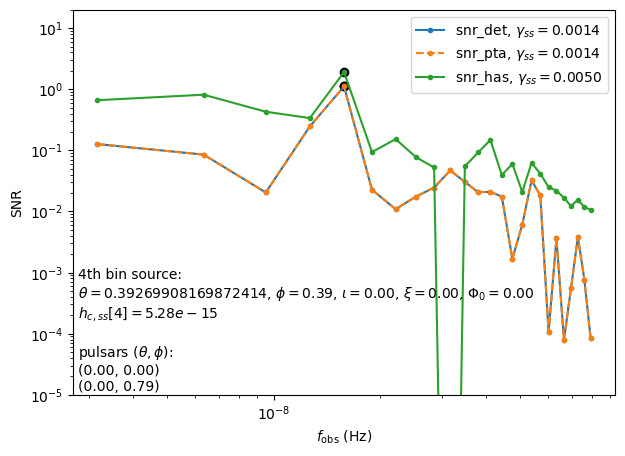

In [53]:
dp_det, snr_det = det.detect_ss(thetas, phis, sigmas, cad, dur, fobs, dfobs, hc_ss, hc_bg,
                                ret_SNR = True, theta_ss=theta_ss, phi_ss=phi_ss, 
                                iota_ss=iota_ss, xi_ss=xi_ss, Phi0_ss=Phi0_ss)
print(dp_det, snr_det.shape, snr_det.squeeze())
dp_has, snr_has = det.detect_ss_scDeter(pulsars, scDeter, hc_ss,
                                ret_SNR = True, theta_ss=theta_ss, phi_ss=phi_ss, 
                                iota_ss=iota_ss, xi_ss=xi_ss, Phi0_ss=Phi0_ss)
print(dp_has, snr_has.shape, snr_has.squeeze())

plot_snr()


In [54]:
# reset_ss()
hc_ss[ss,0,0] = 4*2.64e-15

[0.00943563] (25, 1, 1) [1.26576603e-01 8.50295005e-02 2.04304616e-02 2.46391233e-01
 2.22142208e+00 2.26222578e-02 1.08912941e-02 1.75000359e-02
 2.45543557e-02 4.68226789e-02 3.03803928e-02 2.06549215e-02
 2.08821884e-02 1.74965090e-02 1.67184174e-03 6.05793280e-03
 3.22474607e-02 1.82505398e-02 1.06134249e-04 3.64197715e-03
 7.84005147e-05 5.57551143e-04 3.82592778e-03 7.59976659e-04
 8.34541798e-05]
[0.18861792] (25, 1, 1) [6.61237187e-01 8.12995220e-01 4.27891824e-01 3.36891749e-01
 3.81941558e+00 9.35011668e-02 1.52804861e-01 7.70281185e-02
 5.24176509e-02 2.27765923e-16 5.44733215e-02 9.24537704e-02
 1.47663380e-01 3.93477380e-02 6.00081621e-02 2.07039051e-02
 6.24722628e-02 4.15014056e-02 2.49755611e-02 2.19035274e-02
 1.66736047e-02 1.22178538e-02 1.55650733e-02 1.17478797e-02
 1.06776125e-02]


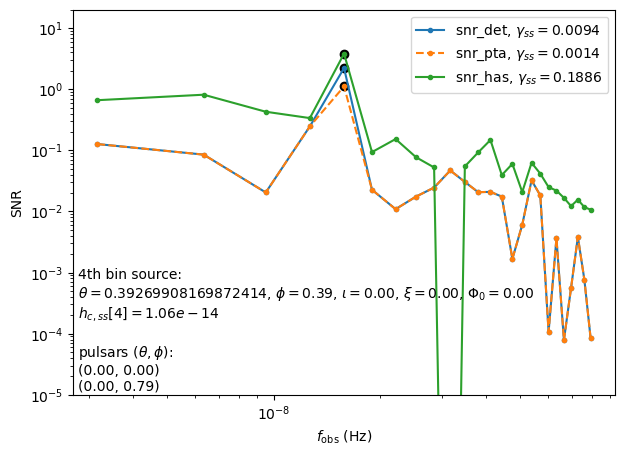

In [55]:
dp_det, snr_det = det.detect_ss(thetas, phis, sigmas, cad, dur, fobs, dfobs, hc_ss, hc_bg,
                                ret_SNR = True, theta_ss=theta_ss, phi_ss=phi_ss, 
                                iota_ss=iota_ss, xi_ss=xi_ss, Phi0_ss=Phi0_ss)
print(dp_det, snr_det.shape, snr_det.squeeze())
dp_has, snr_has = det.detect_ss_scDeter(pulsars, scDeter, hc_ss,
                                ret_SNR = True, theta_ss=theta_ss, phi_ss=phi_ss, 
                                iota_ss=iota_ss, xi_ss=xi_ss, Phi0_ss=Phi0_ss)
print(dp_has, snr_has.shape, snr_has.squeeze())

plot_snr()


# Isolate inclination

[0.00943563] (25, 1, 1) [1.26576603e-01 8.50295005e-02 2.04304616e-02 2.46391233e-01
 1.11071104e+00 2.26222578e-02 1.08912941e-02 1.75000359e-02
 2.45543557e-02 4.68226789e-02 3.03803928e-02 2.06549215e-02
 2.08821884e-02 1.74965090e-02 1.67184174e-03 6.05793280e-03
 3.22474607e-02 1.82505398e-02 1.06134249e-04 3.64197715e-03
 7.84005147e-05 5.57551143e-04 3.82592778e-03 7.59976659e-04
 8.34541798e-05]
[0.18861792] (25, 1, 1) [6.61237187e-01 8.12995220e-01 4.27891824e-01 3.36891749e-01
 3.81941558e+00 9.35011668e-02 1.52804861e-01 7.70281185e-02
 5.24176509e-02 2.27765923e-16 5.44733215e-02 9.24537704e-02
 1.47663380e-01 3.93477380e-02 6.00081621e-02 2.07039051e-02
 6.24722628e-02 4.15014056e-02 2.49755611e-02 2.19035274e-02
 1.66736047e-02 1.22178538e-02 1.55650733e-02 1.17478797e-02
 1.06776125e-02]


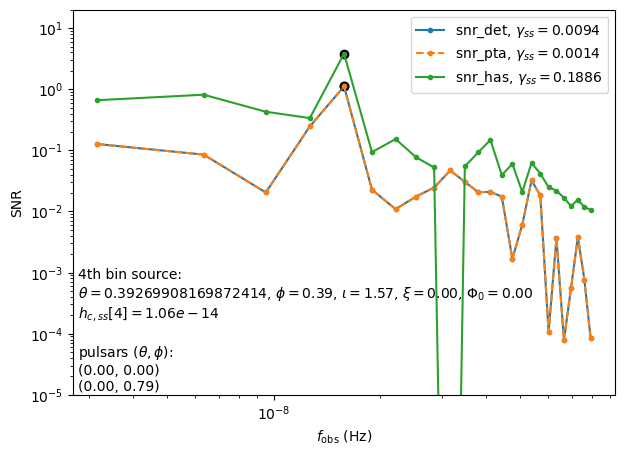

In [56]:
reset_ss()
iota_ss[ss,0,0] = np.pi/2
p_det, snr_det = det.detect_ss(thetas, phis, sigmas, cad, dur, fobs, dfobs, hc_ss, hc_bg,
                                ret_SNR = True, theta_ss=theta_ss, phi_ss=phi_ss, 
                                iota_ss=iota_ss, xi_ss=xi_ss, Phi0_ss=Phi0_ss)
print(dp_det, snr_det.shape, snr_det.squeeze())
dp_has, snr_has = det.detect_ss_scDeter(pulsars, scDeter, hc_ss,
                                ret_SNR = True, theta_ss=theta_ss, phi_ss=phi_ss, 
                                iota_ss=iota_ss, xi_ss=xi_ss, Phi0_ss=Phi0_ss)
print(dp_has, snr_has.shape, snr_has.squeeze())

plot_snr()
